<a href="https://colab.research.google.com/github/ViniciusKanh/PharmaScriptSummarizer/blob/main/Projeto_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

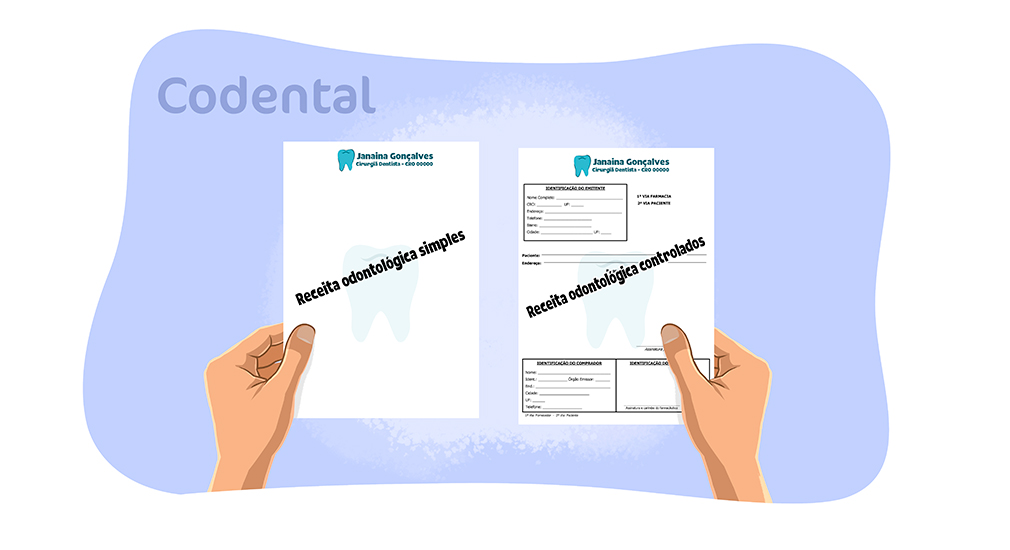
# Reconhecimento e Sumarização de Receitas Médicas Digitalizadas em PDF

## Resumo

Este projeto visa desenvolver um sistema capaz de reconhecer e sumarizar receitas médicas digitalizadas em formato PDF. Através da utilização de técnicas avançadas de processamento digital de imagem e machine learning, o sistema identificará informações críticas, como a dose do medicamento, tempo de uso e nome do médico prescritor. O aumento do uso de prontuários eletrônicos e digitalizações no setor médico torna esse projeto altamente relevante para aprimorar a eficiência e precisão na gestão de informações médicas.


---


## Introdução

O avanço tecnológico na área da saúde tem permitido a digitalização crescente de registros médicos, garantindo mais segurança e praticidade no armazenamento e acesso a informações de pacientes. Dentro desse contexto, receitas médicas representam um dos documentos mais frequentemente digitalizados, dada sua importância e necessidade de compartilhamento entre farmácias, médicos e pacientes (Smith, A. & Johnson, B., 2018). No entanto, o acesso eficiente e a interpretação correta desses documentos digitalizados permanecem como desafios, principalmente devido à variabilidade de formatos e estilos de escrita (Brown, C., 2020). Assim, a implementação de sistemas automatizados que possam identificar e sumarizar essas informações torna-se de suma importância.

## Objetivo Geral

Desenvolver um sistema automatizado capaz de reconhecer e sumarizar informações essenciais de receitas médicas digitalizadas em formato PDF.

### Vinculando meu Driver para armazenamento e estração dos Arquivos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Intalação de Bibliotecas importantes

In [ ]:
!pip install pypdf2
!pip install Pillow pypdf2
!apt-get install -y libtesseract-dev
!pip install pytesseract
!pip install ipywidgets
!apt install -y tesseract-ocr tesseract-ocr-por
!pip install plyer


Importando Bibliotecas

In [ ]:
import PyPDF2
import re
from PIL import Image
import pytesseract
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from IPython.display import display
from ipywidgets import widgets
from google.colab import files
import io
import PyPDF2
from PIL import Image
import pytesseract
import re


Função Extrai Texto

In [ ]:
from IPython.display import display, Image as IPImage
from PIL import Image

def abrir_imagem(image_path):
    display(IPImage(filename=image_path))

In [ ]:
def extrair_texto_do_arquivo(arquivo):
    if arquivo.endswith('.pdf'):
        with open(arquivo, 'rb') as f:
            pdf = PyPDF2.PdfFileReader(f)
            texto = ''.join(page.extractText() for page in pdf.pages)
        return texto
    elif arquivo.endswith('.jpg') or arquivo.endswith('.jpeg'):
        imagem = Image.open(arquivo)
        texto = pytesseract.image_to_string(imagem, lang='por')
        return texto
    else:
        raise ValueError('Formato de arquivo não suportado.')


Função Sumariza Receita

In [ ]:
def preprocess_text(texto):
    # Remover espaços extras
    texto = re.sub(r'\s+', ' ', texto)
    # Correções específicas (se necessário)
    # texto = texto.replace('OR AL', 'ORAL')
    # ...
    return texto



In [ ]:
def find_nearest_date(text, keyword="RECEITUÁRIO"):
    sections = text.split(keyword)
    if len(sections) < 2:
        return "Não encontrado"
    following_text = sections[1]
    date_match = re.search(r"(\d{1,2}/\d{1,2}/\d{4})", following_text)
    return date_match.group(1) if date_match else "Não encontrado"


In [ ]:
def sumarizar_receita(texto):
    print(f"Texto recebido: {texto[:300]}...")  # Diagnóstico
    texto = preprocess_text(texto)

    data_match = re.search(r'Assinado digitalmente em:\s+(\d{2}/\d{2}/\d{4})', texto)
    data_receita = data_match.group(1) if data_match else 'Não encontrada'

    if data_receita == 'Não encontrada':
      # Inclusão da nova função para encontrar a data mais próxima do "RECEITUÁRIO"
      data_receita = find_nearest_date(texto)

    # Extrair CRM do médico
    crm_medico = re.search(r"CRM[-\s]?[A-Za-z]*[-\s]?(\d{5,6})", texto)
    crm_medico = crm_medico.group(1) if crm_medico else "Não encontrado"


    # Extrair nome do medicamento, dosagem e frequência
    medicamento_match = re.findall(r'(\d\.)? ([^\d]+) (\d+mg)', texto)

    medicamentos = []
    for m in medicamento_match:
        nome_med = m[1].strip()
        dose = m[2].strip()

        # Procurar por uma instrução de "Tomar" relacionada ao medicamento
        freq_match = re.search(r'{}.*?Tomar (.+?)(\.|\))'.format(re.escape(nome_med)), texto)

        frequencia = freq_match.group(1).replace('.', '').strip() if freq_match else 'Frequência não especificada'

        medicamentos.append({
            'Medicamento': nome_med,
            'Dose': dose,
            'Frequência': frequencia
        })

    return {
        'Receita emitida em': data_receita,
        'Medicamentos': medicamentos,
        'CRM do Médico': crm_medico
    }

# Testar a função com as receitas fornecidas
texto_receita = "..."  # Substitua "..." pelo texto real da receita
resultado = sumarizar_receita(texto_receita)
print(resultado)

Texto recebido: ......
{'Receita emitida em': 'Não encontrado', 'Medicamentos': [], 'CRM do Médico': 'Não encontrado'}


In [ ]:
def apresentar_resultado(resultado):
    # Criar o cabeçalho com o nome do arquivo e a data de emissão da receita
    output = f"Nome do Arquivo: {resultado.get('Nome do Arquivo', 'Desconhecido')}\n"
    output += "-" * len(output) + "\n"
    output += f"Data da Receita: {resultado['Receita emitida em']}\n"
    output += f"CRM do Médico: {resultado['CRM do Médico']}\n\n"

    # Se não houver medicamentos listados, incluir essa informação
    if not resultado.get('Medicamentos'):
        output += "Nenhum medicamento encontrado.\n"
    else:
        # Caso contrário, listar cada medicamento
        output += "Medicamentos prescritos:\n"
        for idx, med in enumerate(resultado['Medicamentos'], start=1):
            output += f"{idx}. {med['Medicamento']} ({med['Dose']})\n"
            output += f"   Frequência: {med['Frequência']}\n\n"

    return output

# Dados de exemplo
resultado = {
    'Nome do Arquivo': 'Receita Menato (8).pdf',
    'Receita emitida em': 'Não encontrada',
    'Medicamentos': [
        {'Medicamento': 'Oxalato de escitalopram', 'Dose': '10mg', 'Frequência': '1 cp se crises de ansiedade'},
        # ... outros medicamentos ...
    ],
    'CRM do Médico': '183747'
}

# Apresentar o resultado estilizado
print(apresentar_resultado(resultado))


Nome do Arquivo: Receita Menato (8).pdf
----------------------------------------
Data da Receita: Não encontrada
CRM do Médico: 183747

Medicamentos prescritos:
1. Oxalato de escitalopram (10mg)
   Frequência: 1 cp se crises de ansiedade




Escolhendo Arquivo

In [ ]:
from IPython.display import display, clear_output
from google.colab import files
import io
import ipywidgets as widgets
import PyPDF2
from PIL import Image
import pytesseract
import re

# Variáveis Globais
texto = None
ultimo_texto_processado = None  # Variável para armazenar o último texto processado

# Aprimoramento do OCR para imagens
def aprimorar_ocr(image):
    # Realizar operações para melhorar a qualidade da imagem, se necessário
    return pytesseract.image_to_string(image, lang='por')

def on_upload_button_pressed(change):
    global texto
    clear_output(wait=True)
    uploaded_files = files.upload()

    # Verifica se um arquivo foi carregado
    if not uploaded_files:
        print("Nenhum arquivo carregado.")
        return

    # Pegando o primeiro arquivo carregado
    file_name, file_content = next(iter(uploaded_files.items()))

    # Identificar se é PDF ou JPG e extrair o texto
    if file_name.lower().endswith('.pdf'):
        with io.BytesIO(file_content) as f:
            leitor = PyPDF2.PdfReader(f)
            texto = ""
            for pagina in range(len(leitor.pages)):
                texto += leitor.pages[pagina].extract_text()
    elif file_name.lower().endswith(('.jpg', '.jpeg')):
        image = Image.open(io.BytesIO(file_content))
        texto = aprimorar_ocr(image)
    else:
        print("Formato de arquivo não suportado.")
        return

    # Sumarizar o texto extraído
    resultado = sumarizar_receita(texto)

    # Apresentar de forma estilizada
    print(apresentar_resultado(resultado))
    display(upload_button, output)  # Exibe novamente o botão após processamento

# Interface
upload_button = widgets.Button(description="Escolher Arquivo")
output = widgets.Output()

upload_button.on_click(on_upload_button_pressed)
display(upload_button, output)


Saving Receita Menato.pdf to Receita Menato.pdf
Texto recebido: *Para validar assinatura deste documento, acesse https://validador.memed.com.br | Token: jL46ybNome: Giovana Perazzolo Menato
CPF: 469.036.188-64
MEMED - Acesso à sua receita digital via QR Code
Endereço: Rua Teodoro Sampaio, 744 cj102
Assinado digitalmente por Raphael Nacarelli Salgado - CRM 183747...
Nome do Arquivo: Desconhecido
------------------------------
Data da Receita: 30/01/2023
CRM do Médico: 183747

Medicamentos prescritos:
1. Oxalato de escitalopram (10mg)
   Frequência: 1 cp se crises de ansiedade

2. embalagem Oxalato de escitalopram (10mg)
   Frequência: 1 cp se crises de ansiedade

3. Endereço: Estrada do Lutero, Cotia IDENTIFICAÇÃO DO COMPRADOR Nome: RG: Endereço: Telefone: Cidade e UF:IDENTIFICAÇÃO DO FORNECEDOR DATA ASSINATURA DO FARMACÊUTICOOxalato de escitalopram (10mg)
   Frequência: Frequência não especificada

4. embalagem Oxalato de escitalopram (10mg)
   Frequência: 1 cp se crises de ansiedade



Button(description='Escolher Arquivo', style=ButtonStyle())

Output()

### Função para enviar e-mail

In [ ]:
def enviar_lembrete(email_destinatario, medicamentos, dose):
    remetente = "vinicius.santos@ifsp.edu.br"
    senha = "@I_F_S_P_40150785"
    assunto = f"Lembrete para Tomar {medicamentos}"
    corpo = f"""Caro paciente,\n\nEste é um lembrete para tomar o seu medicamento.\n\nNome do Medicamento: {medicamentos}\nDosagem: {dose}\n\nAtenciosamente,\nEquipe de Saúde"""

    mensagem = MIMEMultipart()
    mensagem["From"] = remetente
    mensagem["To"] = email_destinatario
    mensagem["Subject"] = assunto
    mensagem.attach(MIMEText(corpo, 'plain'))

    servidor = smtplib.SMTP_SSL("smtp.gmail.com", 465)
    servidor.login(remetente, senha)
    servidor.sendmail(remetente, email_destinatario, mensagem.as_string())
    servidor.quit()

Widget para upload de arquivo

In [ ]:
upload_button = widgets.FileUpload(
    accept='.pdf,.jpg,.jpeg',
    multiple=False
)

Widget para inserir e-mail

In [ ]:
email_widget = widgets.Text(
    placeholder='Digite o email do destinatário',
    description='Email:',
    disabled=False
)

Botão para enviar lembrete

In [ ]:
send_button = widgets.Button(
    description='Enviar Lembrete'
)

Limpar todos os manipuladores de evento antes de associar um novo

In [ ]:
send_button.close()
send_button = widgets.Button(description='Enviar Lembrete')


Função chamada quando o botão é clicado

In [ ]:
def on_button_click(b):
    print("Botão clicado.")  # Diagnóstico
    global texto
    resultado = sumarizar_receita(texto)
    email_destinatario = email_widget.value

    medicamentos_lista = resultado.get('Medicamentos', [])

    if not medicamentos_lista:
        print("Nenhum medicamento encontrado.")
        return

    primeiro_medicamento = medicamentos_lista[0]
    medicamento_nome = primeiro_medicamento.get('Medicamento', 'Indefinido')
    dose = primeiro_medicamento.get('Dose', 'Indefinida')

    enviar_lembrete(email_destinatario, medicamento_nome, dose)


In [ ]:
send_button.on_click(on_button_click)

# Mostrar widgets
display(email_widget, send_button)

Text(value='', description='Email:', placeholder='Digite o email do destinatário')

Button(description='Enviar Lembrete', style=ButtonStyle())

Botão clicado.
Texto recebido: *Para validar assinatura deste documento, acesse https://validador.memed.com.br | Token: jL46ybNome: Giovana Perazzolo Menato
CPF: 469.036.188-64
MEMED - Acesso à sua receita digital via QR Code
Endereço: Rua Teodoro Sampaio, 744 cj102
Assinado digitalmente por Raphael Nacarelli Salgado - CRM 183747...
Botão clicado.
Texto recebido: *Para validar assinatura deste documento, acesse https://validador.memed.com.br | Token: jL46ybNome: Giovana Perazzolo Menato
CPF: 469.036.188-64
MEMED - Acesso à sua receita digital via QR Code
Endereço: Rua Teodoro Sampaio, 744 cj102
Assinado digitalmente por Raphael Nacarelli Salgado - CRM 183747...
Botão clicado.
Texto recebido: *Para validar assinatura deste documento, acesse https://validador.memed.com.br | Token: jL46ybNome: Giovana Perazzolo Menato
CPF: 469.036.188-64
MEMED - Acesso à sua receita digital via QR Code
Endereço: Rua Teodoro Sampaio, 744 cj102
Assinado digitalmente por Raphael Nacarelli Salgado - CRM 18374